In [2]:
import os
import wfdb
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

def load_mitbih_dataset(path):
    # Define a list of annotation symbols that represent different types of heartbeats
    annots_list = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

    # Prepare empty lists to store signal segments and corresponding labels
    X = []
    y = []

    # Create a dictionary to map each annotation symbol to a unique integer
    annot_to_int = {annot: i for i, annot in enumerate(annots_list)}

    # Read the list of ECG record filenames from the 'RECORDS' file in the dataset directory
    record_list = []
    with open(os.path.join(path, 'RECORDS'), 'r') as file:
        record_list = [line.strip() for line in file]

    # Create an instance of the MinMaxScaler to scale each segment to the range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Iterate over each record file in the dataset
    for record_name in record_list:
        # Load the ECG record and its annotations using the wfdb library
        record = wfdb.rdrecord(os.path.join(path, record_name))
        annotation = wfdb.rdann(os.path.join(path, record_name), 'atr')

        # Extract the first channel of the ECG signal (assuming it's a single-channel ECG)
        signal = record.p_signal[:, 0]
        # Get the symbols and sample locations for each annotated beat
        beat_annotations = annotation.symbol
        beat_locations = annotation.sample

        # Process each annotated beat in the current record
        for sym, loc in zip(beat_annotations, beat_locations):
            # Check if the annotation symbol is one of the types we're interested in
            if sym in annots_list:
                # Convert the annotation symbol to its corresponding integer label
                label = annot_to_int[sym]
                
                # Define the window size around the beat location to extract the segment
                win_size = 625  # This results in segments of 1250 samples centered on the beat
                # Ensure that the window does not extend beyond the signal boundaries
                if loc - win_size >= 0 and loc + win_size <= len(signal):
                    # Extract the segment of the signal centered around the beat
                    segment = signal[loc - win_size: loc + win_size]
                    # Normalize the segment to the range [0, 1]
                    segment = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
                    # Add the normalized segment to the list of segments
                    X.append(segment)
                    # Add the label to the list of labels
                    y.append(label)

    # Convert the lists of segments and labels to numpy arrays for use in machine learning models
    X = np.array(X)
    # Convert the integer labels to one-hot encoded format
    y = to_categorical(y, num_classes=len(annots_list))

    return X, y


2024-05-16 15:25:43.362090: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 15:25:43.392386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 15:25:43.392415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 15:25:43.393067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 15:25:43.398032: I tensorflow/core/platform/cpu_feature_guar

In [4]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import KFold
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Define the CNN-only model function
def create_cnn_only_model(num_classes, input_shape=(1250, 1), optimizer_type='adam', learning_rate=0.001):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model



        

In [5]:
def cross_validate_model(X, y, k=10, epochs=10):
    """
    Perform K-fold cross-validation on the CNN-only model.

    Args:
    X (numpy array): Feature dataset.
    y (numpy array): Labels for the dataset.
    k (int): Number of folds for cross-validation. Default is 10.
    epochs (int): Number of epochs to train each model. Default is 10.

    Returns:
    all_results (list): List of evaluation results for each fold.
    total_elapsed_time (float): Total time taken for cross-validation.
    """
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    all_results = []
    total_start_time = time.time()

    for train, test in kfold.split(X, y):
        print(f'Training fold {fold_no}...')
        fold_start_time = time.time()

        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        model = create_cnn_only_model(num_classes=y_train.shape[1], input_shape=(X_train.shape[1], 1))

        model_checkpoint_path = f'./model_fold_{fold_no}.h5'

        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            keras.callbacks.ModelCheckpoint(model_checkpoint_path, save_best_only=True, verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
        ]

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=8, validation_data=(X_test, y_test), callbacks=callbacks)

        fold_end_time = time.time()
        fold_elapsed_time = fold_end_time - fold_start_time
        print(f'Fold {fold_no} completed in {fold_elapsed_time:.2f} seconds.')
        results = model.evaluate(X_test, y_test, verbose=1)
        all_results.append(results)

        fold_no += 1

    total_end_time = time.time()
    total_elapsed_time = total_end_time - total_start_time
    print(f'Total cross-validation time: {total_elapsed_time:.2f} seconds.')

    return all_results, total_elapsed_time

data_path = "/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/"
X, y = load_mitbih_dataset(data_path)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Perform cross-validation
results, total_time = cross_validate_model(X, y, k=10, epochs=10)

# Save cross-validation results
with open('cross_validation_results.json', 'w') as f:
    json.dump(results, f)

print("Cross-validation completed. Results saved.")

Training fold 1...


2024-05-16 15:26:36.430771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8231 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-05-16 15:26:36.431311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8084 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:68:00.0, compute capability: 8.6


Epoch 1/10


2024-05-16 15:26:38.345961: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-16 15:26:39.342035: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f436d337dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-16 15:26:39.342085: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-16 15:26:39.342098: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-16 15:26:39.353308: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715898399.468363  352502 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12295/12295 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9405 - precision: 0.9565 - recall: 0.9225
Epoch 1: val_loss improved from inf to 0.08770, saving model to ./model_fold_1.h5
12295/12295 [==============================] - 108s 9ms/step - loss: 0.2242 - accuracy: 0.9405 - precision: 0.9565 - recall: 0.9225 - val_loss: 0.0877 - val_accuracy: 0.9751 - val_precision: 0.9776 - val_recall: 0.9729 - lr: 0.0010
Epoch 2/10
   16/12295 [..............................] - ETA: 1:24 - loss: 0.1237 - accuracy: 0.9688 - precision: 0.9688 - recall: 0.9688

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12290/12295 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9714 - precision: 0.9758 - recall: 0.9673
Epoch 2: val_loss improved from 0.08770 to 0.06695, saving model to ./model_fold_1.h5
12295/12295 [==============================] - 105s 9ms/step - loss: 0.1076 - accuracy: 0.9714 - precision: 0.9759 - recall: 0.9673 - val_loss: 0.0670 - val_accuracy: 0.9831 - val_precision: 0.9842 - val_recall: 0.9819 - lr: 0.0010
Epoch 3/10
12295/12295 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9783 - precision: 0.9809 - recall: 0.9756
Epoch 3: val_loss did not improve from 0.06695
12295/12295 [==============================] - 105s 9ms/step - loss: 0.0830 - accuracy: 0.9783 - precision: 0.9809 - recall: 0.9756 - val_loss: 0.0672 - val_accuracy: 0.9844 - val_precision: 0.9849 - val_recall: 0.9833 - lr: 0.0010
Epoch 4/10
12292/12295 [============================>.] - ETA: 0s - loss: 0.0740 - accuracy: 0.9805 - precision: 0.9827 - recall: 0.9780
Epo

Model for fold 1 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0571 - accuracy: 0.9888 - precision: 0.9892 - recall: 0.9885
Test Loss, Test Accuracy, and other metrics for fold 1: [0.057104114443063736, 0.9888370633125305, 0.9891951084136963, 0.9884710311889648]
Evaluation time for fold 1: 1.87 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 1:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      7506
           L       1.00      1.00      1.00       806
           R       0.99      1.00      1.00       775
           e       0.00      0.00      0.00         1
           j       0.91      0.68      0.78        31
           A       0.95      0.91      0.93       221
           a       1.00      0.43      0.60        14
           J       1.00      0.25      0.40         8
           V       0.97      0.98      0.97       692
           E       1.00  

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

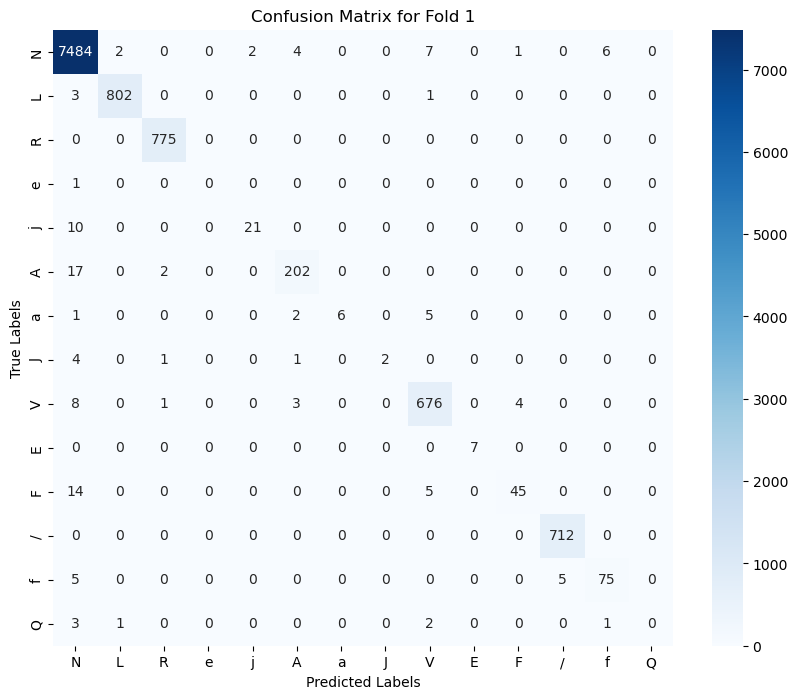

Model for fold 2 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0667 - accuracy: 0.9838 - precision_1: 0.9860 - recall_1: 0.9818
Test Loss, Test Accuracy, and other metrics for fold 2: [0.06668928265571594, 0.9838045835494995, 0.9860320091247559, 0.9817915558815002]
Evaluation time for fold 2: 1.86 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 2:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      7489
           L       0.99      0.99      0.99       788
           R       0.99      1.00      0.99       725
           e       0.00      0.00      0.00         1
           j       0.88      0.39      0.54        18
           S       0.00      0.00      0.00         1
           A       0.96      0.87      0.91       246
           a       1.00      0.23      0.38        13
           J       0.00      0.00      0.00         4
           V       0.9

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

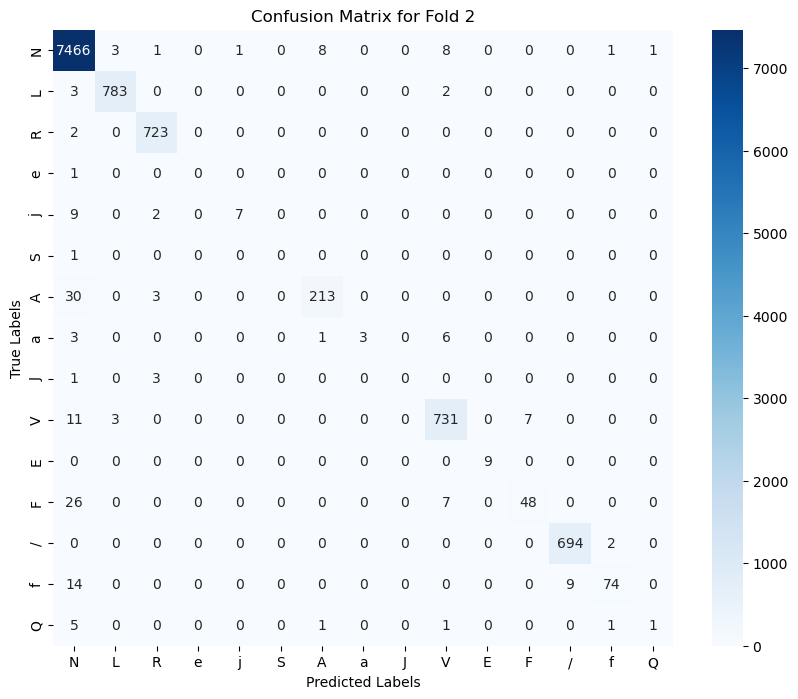

Model for fold 3 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0625 - accuracy: 0.9863 - precision_2: 0.9873 - recall_2: 0.9851
Test Loss, Test Accuracy, and other metrics for fold 3: [0.06251885741949081, 0.9862750768661499, 0.9873440861701965, 0.9850855469703674]
Evaluation time for fold 3: 1.87 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 3:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      7514
           L       0.99      1.00      0.99       849
           R       0.99      0.99      0.99       731
           j       1.00      0.57      0.72        23
           A       0.96      0.86      0.91       247
           a       1.00      0.73      0.84        11
           J       0.00      0.00      0.00         8
           V       0.97      0.97      0.97       707
           E       1.00      0.80      0.89        10
           F       0.9

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

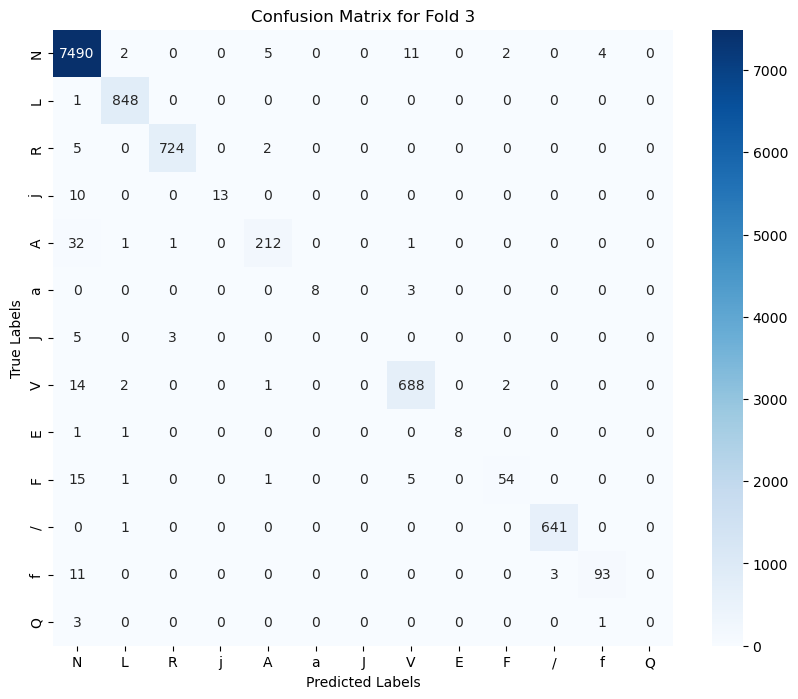

Model for fold 4 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0644 - accuracy: 0.9901 - precision_3: 0.9905 - recall_3: 0.9899
Test Loss, Test Accuracy, and other metrics for fold 4: [0.06439754366874695, 0.9901180267333984, 0.9904788136482239, 0.989935040473938]
Evaluation time for fold 4: 1.87 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 4:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      7490
           L       1.00      1.00      1.00       833
           R       1.00      0.99      0.99       711
           e       0.00      0.00      0.00         2
           j       1.00      0.48      0.65        21
           S       0.00      0.00      0.00         1
           A       0.96      0.94      0.95       251
           a       1.00      0.80      0.89        15
           J       1.00      0.29      0.44         7
           V       0.98

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

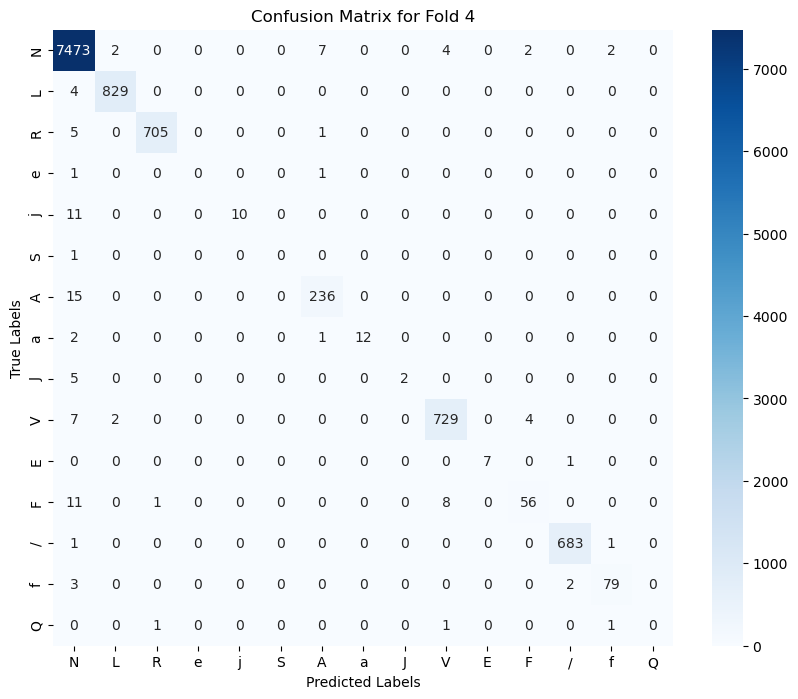

Model for fold 5 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0542 - accuracy: 0.9867 - precision_4: 0.9875 - recall_4: 0.9857
Test Loss, Test Accuracy, and other metrics for fold 5: [0.05420256406068802, 0.986732542514801, 0.9875332117080688, 0.9857260584831238]
Evaluation time for fold 5: 1.88 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 5:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      7491
           L       1.00      0.99      0.99       799
           R       0.99      1.00      0.99       749
           e       0.00      0.00      0.00         2
           j       0.92      0.55      0.69        20
           A       0.96      0.90      0.93       278
           a       1.00      0.64      0.78        14
           J       1.00      0.20      0.33         5
           V       0.97      0.97      0.97       718
           E       1.00

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

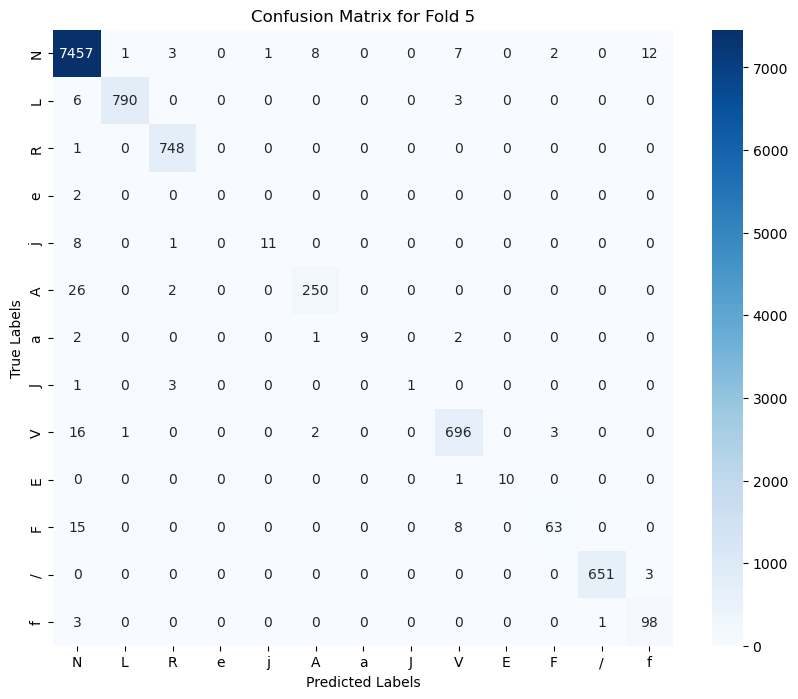

Model for fold 6 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0611 - accuracy: 0.9846 - precision_5: 0.9852 - recall_5: 0.9840
Test Loss, Test Accuracy, and other metrics for fold 6: [0.06108374148607254, 0.9846280813217163, 0.9852496385574341, 0.98398756980896]
Evaluation time for fold 6: 1.88 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 6:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      7409
           L       1.00      0.98      0.99       769
           R       0.99      0.99      0.99       752
           j       0.94      0.68      0.79        25
           A       0.99      0.85      0.91       257
           a       1.00      0.47      0.64        17
           J       1.00      0.25      0.40        12
           V       0.95      0.97      0.96       750
           E       1.00      0.92      0.96        13
           F       0.92 

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

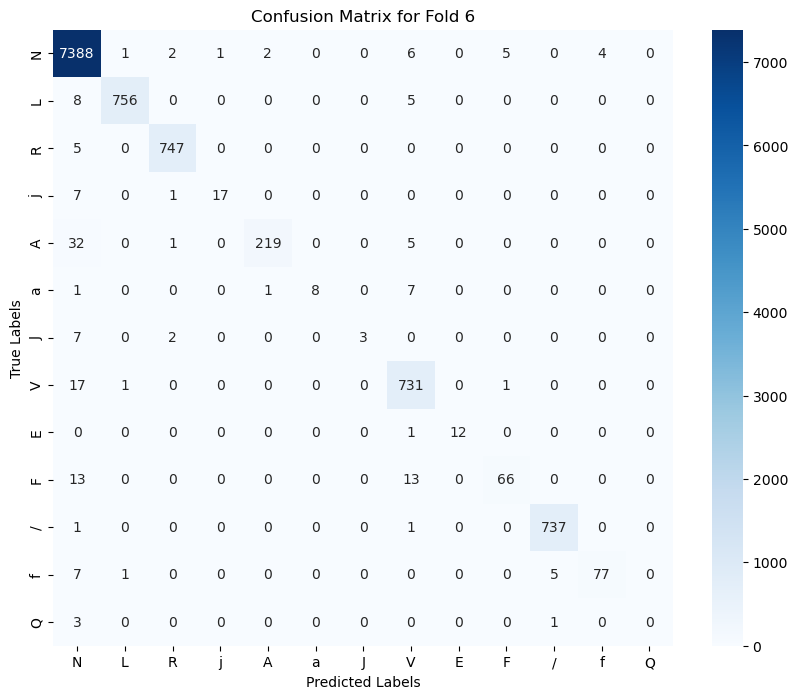

Model for fold 7 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0621 - accuracy: 0.9829 - precision_6: 0.9844 - recall_6: 0.9820
Test Loss, Test Accuracy, and other metrics for fold 7: [0.062135111540555954, 0.9828895330429077, 0.9844065308570862, 0.9819745421409607]
Evaluation time for fold 7: 1.86 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 7:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      7485
           L       0.99      0.99      0.99       792
           R       0.99      1.00      0.99       715
           e       0.00      0.00      0.00         2
           j       0.93      0.52      0.67        27
           A       0.96      0.88      0.92       281
           a       1.00      0.33      0.50        24
           J       1.00      0.08      0.15        12
           V       0.96      0.97      0.96       707
           E       1.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

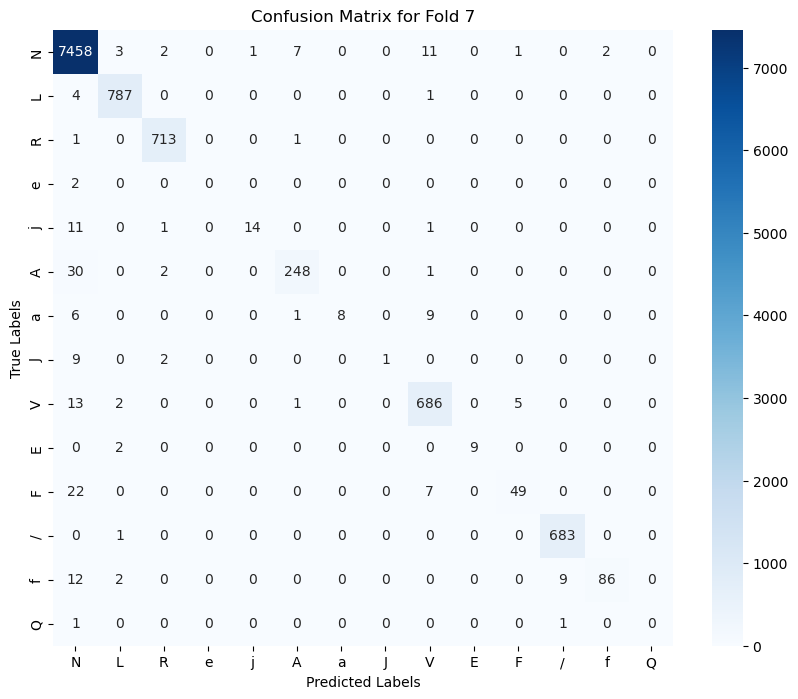

Model for fold 8 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0618 - accuracy: 0.9858 - precision_7: 0.9865 - recall_7: 0.9853
Test Loss, Test Accuracy, and other metrics for fold 8: [0.06177685037255287, 0.985816240310669, 0.9865310788154602, 0.9852672219276428]
Evaluation time for fold 8: 1.87 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 8:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      7549
           L       0.99      0.99      0.99       781
           R       0.99      0.99      0.99       687
           e       0.00      0.00      0.00         1
           j       0.92      0.38      0.54        29
           A       0.93      0.90      0.91       264
           a       1.00      0.50      0.67         8
           J       1.00      0.25      0.40         4
           V       0.98      0.97      0.98       706
           E       1.00

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

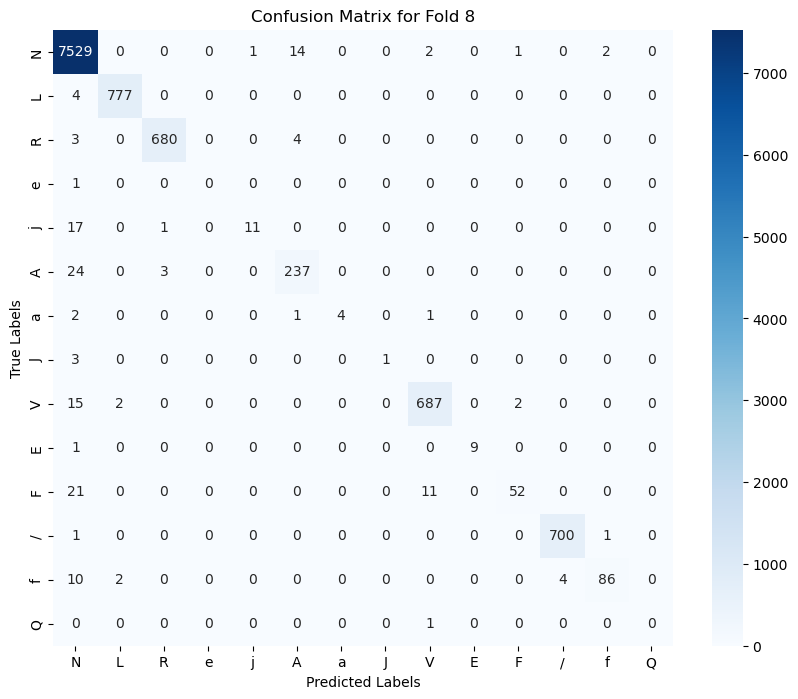

Model for fold 9 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0619 - accuracy: 0.9833 - precision_8: 0.9850 - recall_8: 0.9823
Test Loss, Test Accuracy, and other metrics for fold 9: [0.06189538538455963, 0.9833455085754395, 0.9849527478218079, 0.9823389649391174]
Evaluation time for fold 9: 1.83 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 9:
              precision    recall  f1-score   support

           N       0.98      1.00      0.99      7472
           L       1.00      0.99      0.99       793
           R       0.99      0.99      0.99       682
           e       0.00      0.00      0.00         2
           j       1.00      0.14      0.25        21
           A       0.95      0.85      0.90       249
           a       1.00      0.19      0.32        21
           J       0.00      0.00      0.00        10
           V       0.97      0.97      0.97       710
           E       0.9

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

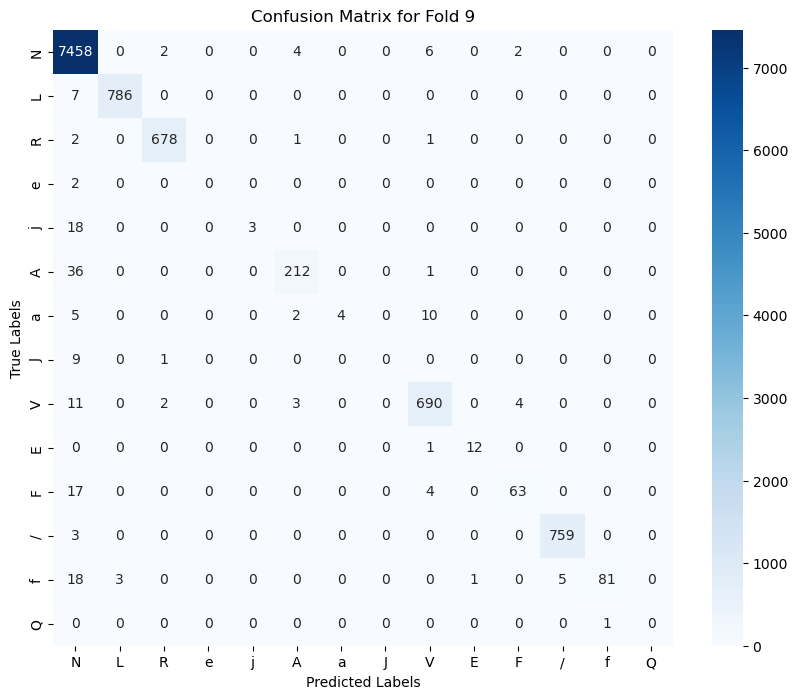

Model for fold 10 loaded successfully.
342/342 [==============================] - 2s 5ms/step - loss: 0.0569 - accuracy: 0.9890 - precision_9: 0.9902 - recall_9: 0.9886
Test Loss, Test Accuracy, and other metrics for fold 10: [0.056876040995121, 0.9890190362930298, 0.9901924729347229, 0.9885615110397339]
Evaluation time for fold 10: 1.87 seconds
342/342 [==============================] - 1s 3ms/step

Classification Report for fold 10:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99      7501
           L       1.00      1.00      1.00       850
           R       0.99      0.99      0.99       718
           e       0.00      0.00      0.00         5
           j       1.00      0.71      0.83        14
           A       0.97      0.89      0.93       248
           a       0.90      0.69      0.78        13
           J       1.00      0.23      0.38        13
           V       0.98      0.97      0.97       637
           E       1

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

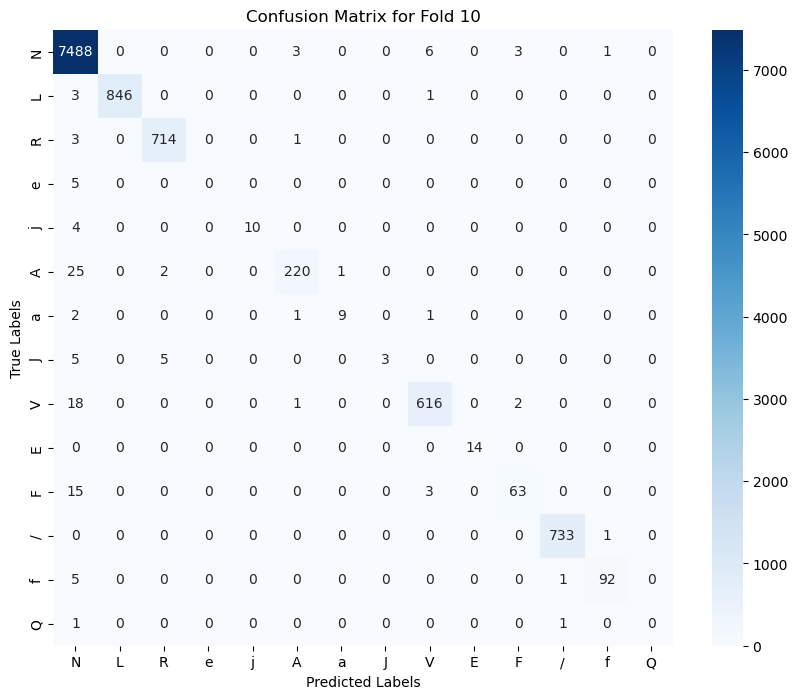


Average metrics across all folds:
Precision: 0.825034844854239
Recall: 0.6846580486387113
F1-Score: 0.725810390027636
Support: 788.2276923076923


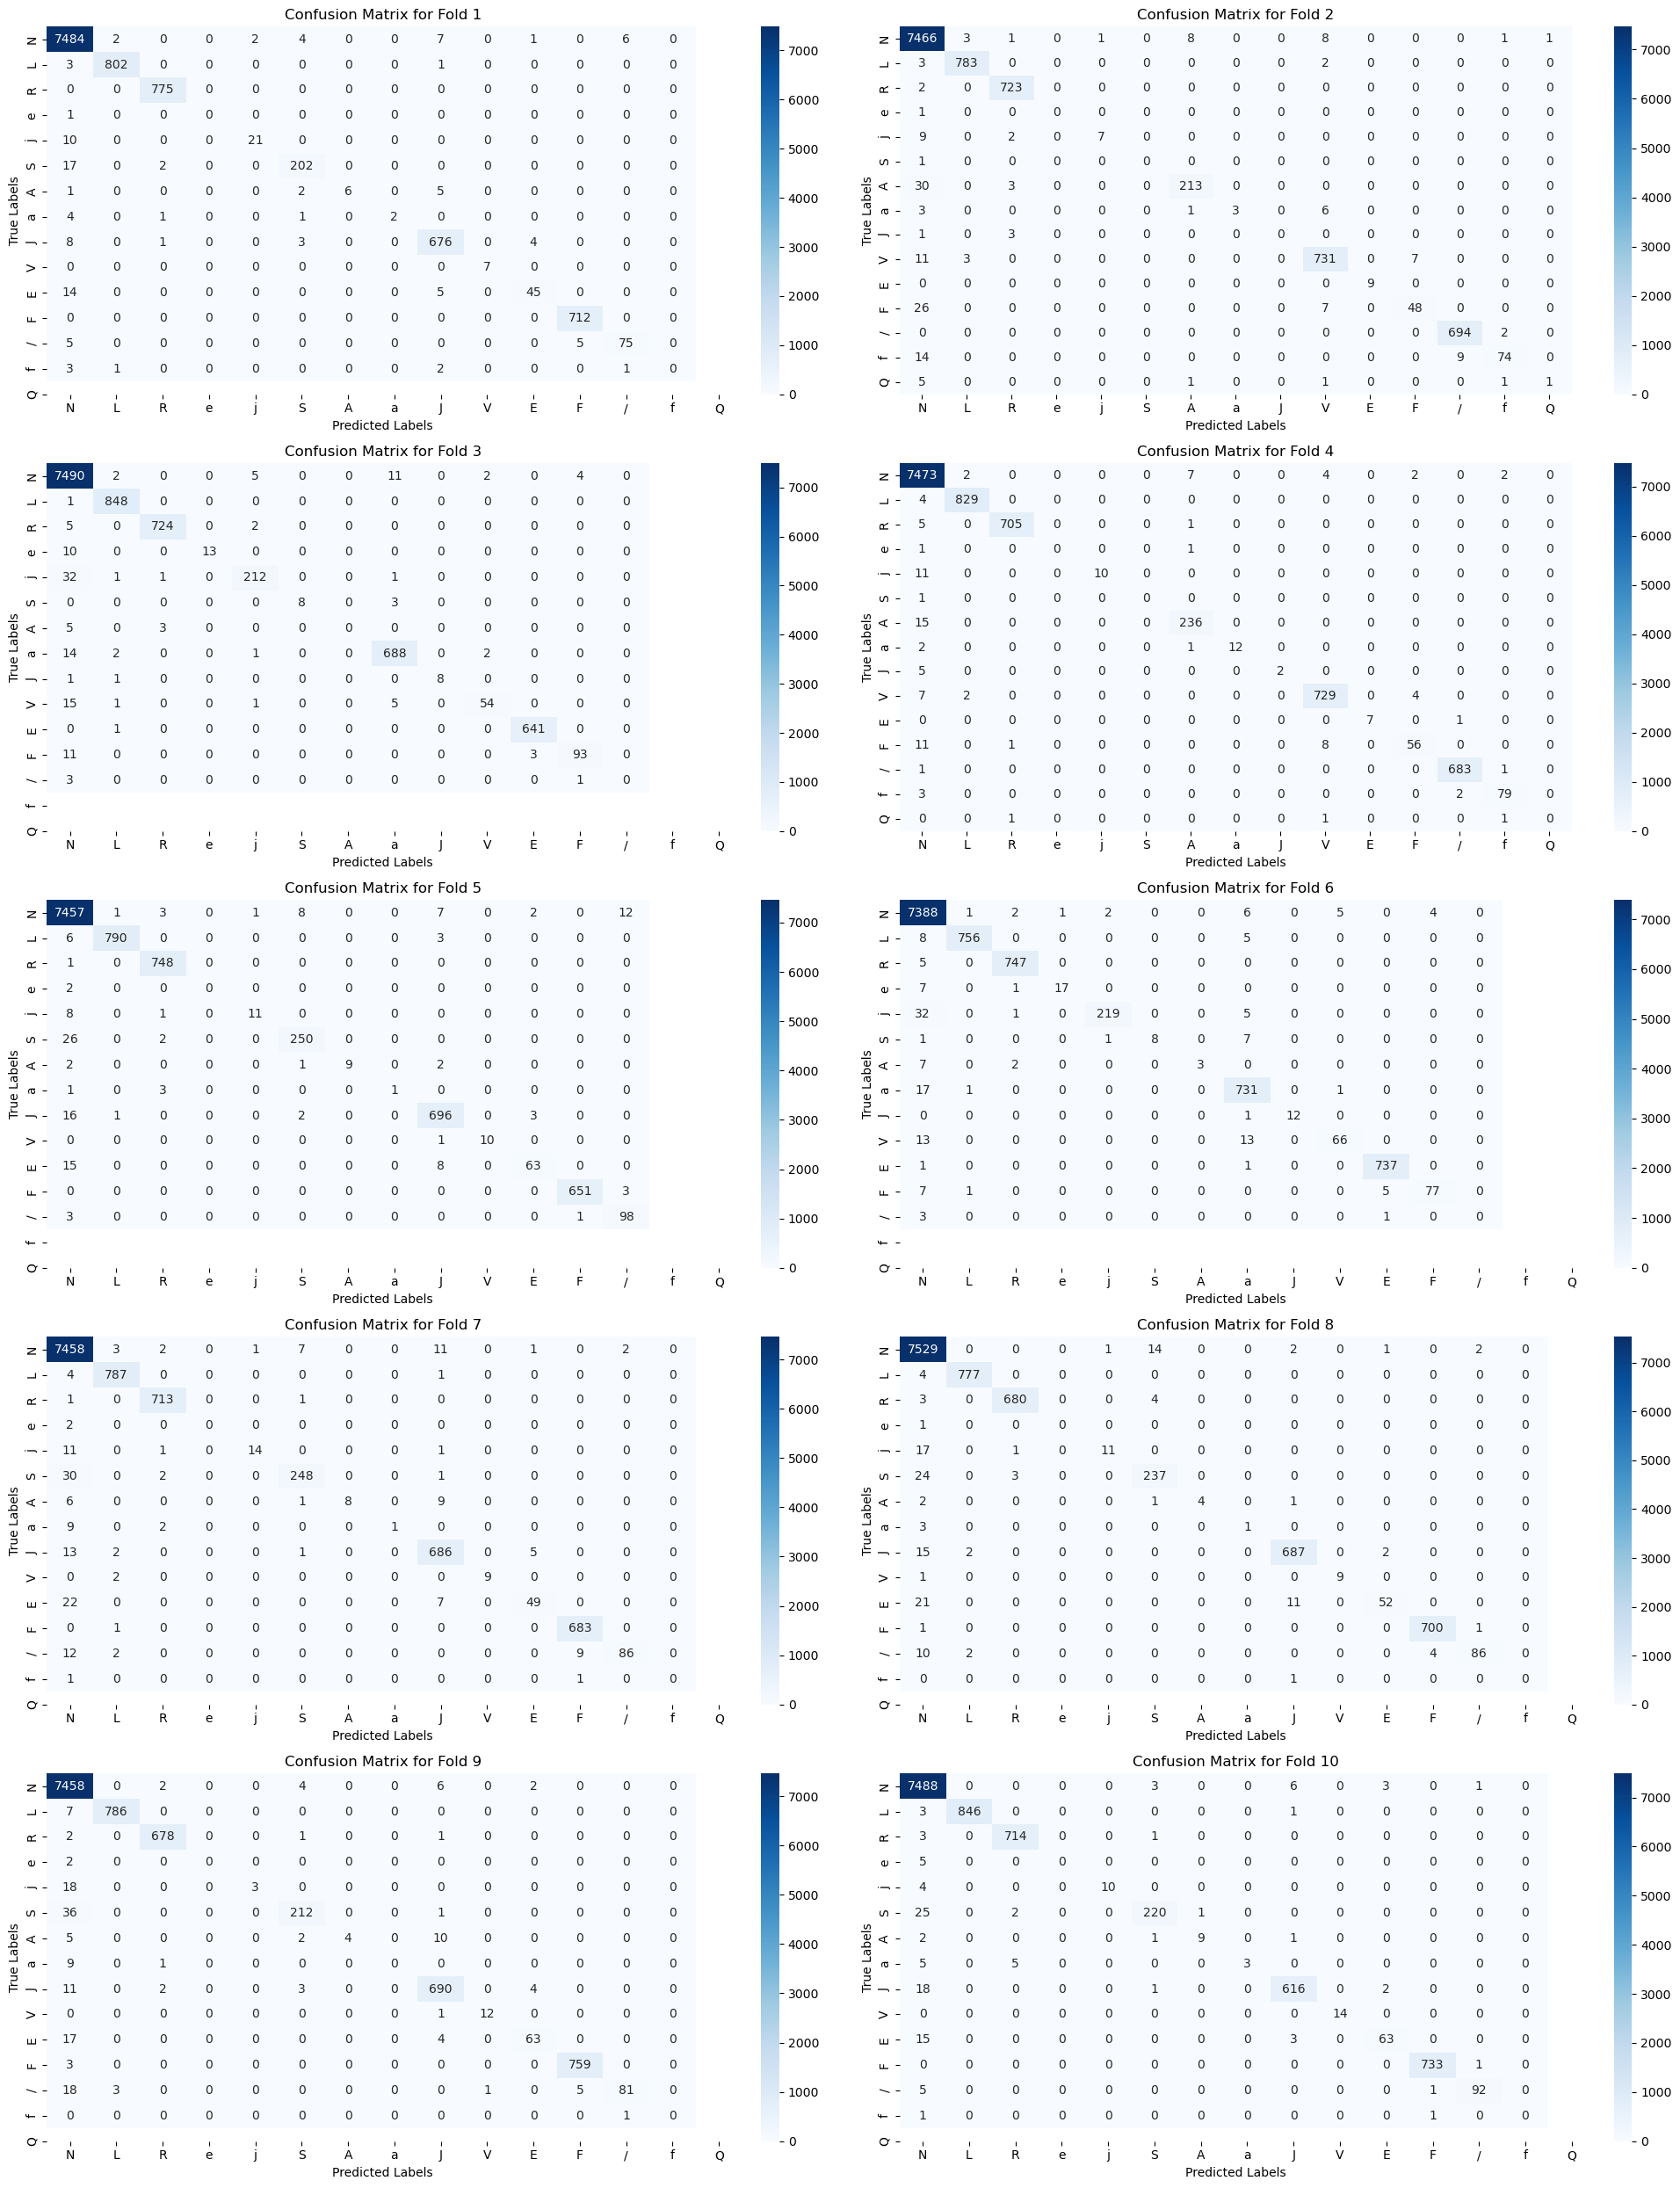

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


# Define the class labels based on your annots_list
class_labels = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

#Evaluation Function
def evaluate_model_on_folds(X, y, k=10):
    """
    Evaluate the trained model on each fold of the K-fold cross-validation.

    Args:
    X (numpy array): Feature dataset.
    y (numpy array): Labels for the dataset.
    k (int): Number of folds for cross-validation. Default is 10.

    Returns:
    all_confusion_matrices (list): List of confusion matrices for each fold.
    all_metrics (list): List of metrics for each fold.
    """
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    all_confusion_matrices = []
    all_metrics = []

    for train, test in kfold.split(X, y):
        model_path = f'./model_fold_{fold_no}.h5'
        if not os.path.exists(model_path):
            print(f'Model file for fold {fold_no} not found!')
            continue

        model = keras.models.load_model(model_path)
        print(f'Model for fold {fold_no} loaded successfully.')

        X_test = X[test]
        y_test = y[test]

        start_time = time.time()
        results = model.evaluate(X_test, y_test, verbose=1)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Test Loss, Test Accuracy, and other metrics for fold {fold_no}: {results}')
        print(f'Evaluation time for fold {fold_no}: {elapsed_time:.2f} seconds')

        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        unique_classes = np.unique(y_true_classes)

        report_dict = classification_report(y_true_classes, y_pred_classes, labels=unique_classes, target_names=[class_labels[i] for i in unique_classes], output_dict=True)
        print(f"\nClassification Report for fold {fold_no}:")
        print(classification_report(y_true_classes, y_pred_classes, labels=unique_classes, target_names=[class_labels[i] for i in unique_classes]))

        cm = confusion_matrix(y_true_classes, y_pred_classes, labels=unique_classes)
        all_confusion_matrices.append(cm)

        metrics = precision_recall_fscore_support(y_true_classes, y_pred_classes, labels=unique_classes)
        all_metrics.append(metrics)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_labels[i] for i in unique_classes], yticklabels=[class_labels[i] for i in unique_classes])
        plt.title(f'Confusion Matrix for Fold {fold_no}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

        fold_no += 1

    return all_confusion_matrices, all_metrics

def calculate_average_metrics(all_metrics):
    """
    Calculate average metrics across all folds.

    Args:
    all_metrics (list): List of metrics for each fold.

    Returns:
    dict: Dictionary containing average precision, recall, F1-score, and support.
    """
    avg_precision = []
    avg_recall = []
    avg_fscore = []
    avg_support = []

    for metrics in all_metrics:
        precision, recall, fscore, support = metrics
        avg_precision.append(np.mean(precision))
        avg_recall.append(np.mean(recall))
        avg_fscore.append(np.mean(fscore))
        avg_support.append(np.mean(support))

    return {
        "avg_precision": np.mean(avg_precision),
        "avg_recall": np.mean(avg_recall),
        "avg_fscore": np.mean(avg_fscore),
        "avg_support": np.mean(avg_support)
    }

# Main function to execute the evaluation
if __name__ == "__main__":
    # Load the dataset
    data_path = "/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/"
    X, y = load_mitbih_dataset(data_path)
    X = X.reshape((X.shape[0], X.shape[1], 1))


    # Evaluate model on each fold
    all_confusion_matrices, all_metrics = evaluate_model_on_folds(X, y, k=10)

    # Calculate and print average metrics
    average_metrics = calculate_average_metrics(all_metrics)

    print("\nAverage metrics across all folds:")
    print(f"Precision: {average_metrics['avg_precision']}")
    print(f"Recall: {average_metrics['avg_recall']}")
    print(f"F1-Score: {average_metrics['avg_fscore']}")
    print(f"Support: {average_metrics['avg_support']}")

    # Visualize all confusion matrices in one figure
    fig, axes = plt.subplots(5, 2, figsize=(20, 25))
    axes = axes.ravel()

    for i in range(10):
        sns.heatmap(all_confusion_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for Fold {i+1}')
        axes[i].set_xlabel('Predicted Labels')
        axes[i].set_ylabel('True Labels')

    plt.tight_layout()
    plt.show()
